In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, Image, HTML
from ipywidgets import AppLayout, Button, Layout, GridspecLayout, IntProgress, Output, VBox, HBox
from numba.typed import List
from numba import njit, prange
from collections import deque
from os import path
import pickle
pd.set_option('display.max_columns', None)

In [2]:
frame = pd.read_csv('./output.csv', index_col=0)
frame['name'] = frame['name'].str.lower().astype('str')
frame['class'] = frame['class'].str.lower().astype('str')
frame[['price']] = frame['price'].fillna(value=0)
if 'status' not in frame.columns:
    frame['status'] = np.full(len(frame), -1)

/home/guillaume/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
with open('./classes.txt') as cl_file:
    classes = [x.strip().lower() for x in cl_file.readlines()]

In [4]:
def to_numba_list(strings):
    result = List()
    for x in strings:
        result.append(x)
    return result
        
        
@njit(parallel=True)
def disable_bad_items_numba(classes, names, statuses):
    for i in prange(len(classes)):
        name = names[i]
        clazz = classes[i]
        ok = False
        for word in clazz:
            if word in name:
                ok=True
                break
        if not ok:
            statuses[i] = 0
            
def disable_bad_items(frame):
    disable_bad_items_numba(to_numba_list(frame['class']), to_numba_list(frame['name']), frame['status'].to_numpy())

def sort_frame(frame):
    frame.sort_values(by='viewCount', kind='mergesort', ascending=False, inplace=True)
    frame.sort_values(by='price', kind='mergesort', inplace=True)
    frame.sort_values(by='class', kind='mergesort', inplace=True)

In [5]:
disable_bad_items(frame)
sort_frame(frame)

<ipython-input-4-814fdbae9d27>:11: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  name = names[i]


In [ ]:
HTML("""
<style>
.
</style>
""")

In [46]:
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

output = Output()

class UI():
    def __init__(self, frame, clazz, output_folder):
        self.frame = frame
        self.clazz = clazz
        self.output_folder = output_folder
        self.todo = deque(list(frame[frame['class'] == clazz].index))
        self.accept = []
        self.reject = []
        self.to_skip = set()
        self.undo_queue = deque()
        
        self.yes_button = create_expanded_button("Yes", 'success')
        self.no_button = create_expanded_button("No", 'danger')
        self.undo_button = create_expanded_button("Undo", 'warning')
        self.save_button = create_expanded_button("Save", 'info')
        
        self.yes_button.on_click(self.yes)
        self.no_button.on_click(self.no)
        self.undo_button.on_click(self.undo)
        self.save_button.on_click(self.save_state)

        self.progress_bar = IntProgress(value=0, min=0, max=len(self.todo), layout=Layout(width='100%' ,height='100%'))

        grid = GridspecLayout(5, 10, height='800px')
        grid[1, :] = self.progress_bar
        grid[2, :4] = self.yes_button
        grid[2, 4:8] = self.no_button
        grid[2, 8] = self.undo_button
        grid[2, 9] = self.save_button
        self.grid = grid
        self.current_id = None
        
        self.load_state()
        
    def update_ui(self):
        if self.current_id == None:
            self.grid[0, :] = HTML(f"""<h2>DONE!!!!!!!</h2>""")
            self.grid[0, :] = HTML(f"""<h2>DONE!!!!!!!</h2>""")
            self.grid[3, :] = HTML(f"""<h2>DONE!!!!!!!</h2>""")
            self.grid[4, :] = HTML(f"""<h2>DONE!!!!!!!</h2>""")
            return
        current_item = self.frame.loc[self.current_id]
        self.grid[0, :] = HTML(f"""<h2>Class: {current_item['class']}</h2>""")
        self.grid[3, :] = HTML(f"""<a target='blank' href='{current_item['viewerUrl']}'>{current_item['name']}</a>, ${current_item['price']/ 100}""")
        image = Image.from_url(current_item['image-3'])
        image.layout = Layout(width='100%', max_height='550px')
        self.grid[4, :] = image
        self.progress_bar.value= len(self.accept) + len(self.reject)
        self.yes_button.description = f"""Yes ({len(self.accept)})"""
        self.no_button.description = f"""No ({len(self.reject)})"""
        
        
    def display(self):
        return self.grid
    
    def next_element(self):
        try:
            self.current_id = self.todo.popleft()
        except:
            self.current_id = None
            self.save_state()
        if self.current_id is not None and self.current_id in self.to_skip:
            self.next_element()
        else:
            self.update_ui()
        
    @property
    def target_path(self):
        return path.join(self.output_folder, f"""class-{self.clazz}.pkl""")
    
    def load_state(self):
        try:
            with open(self.target_path, 'rb') as h:
                state = pickle.load(h)
                self.accept = state['accept']
                self.reject = state['reject']
                for a in state['accept']:
                    self.to_skip.add(a)
                for a in state['reject']:
                    self.to_skip.add(a)
        except:
            pass
        
    
    def save_state(self, *args):
        state = {
            'accept': self.accept,
            'reject': self.reject
        }
        with open(self.target_path, 'wb') as h:
            pickle.dump(state, h)
    
    def yes(self, *args):
        self.accept.append(self.current_id)
        self.undo_queue.append("yes")
        self.next_element()
        
    def no(self, *args):
        self.reject.append(self.current_id)
        self.undo_queue.append("no")
        self.next_element()
        
    def undo(self, *args):
        try:
            to_remove = self.undo_queue.pop()
        except:
            pass
            
        if to_remove == "yes":
            target = self.accept
        else:
            target = self.reject
        element = target.pop()
        self.todo.appendleft(self.current_id)
        self.todo.appendleft(element)
        self.next_element()
    
    
ui = UI(frame, classes[16], './labeling')
ui.next_element()
ui.display()

GridspecLayout(children=(IntProgress(value=0, layout=Layout(grid_area='widget001', height='100%', width='100%'…

In [18]:
HTML("""
<style>
.unselected-image {
    opacity:0.5
}

.my-box {
    position: relative
}
</style>
""")

HTML(value='\n<style>\n.unselected-image {\n    opacity:0.5\n}\n\n.my-box {\n    position: relative\n}\n</styl…

In [135]:
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))


class ImageDisplay():
    def __init__(self, current_item, store):
        self.current_item = current_item
        self.store = store
        try:
            self.image = Image.from_url(current_item['image-3'])
        except:
            self.image = HTML('Unable to load')
        self.selected = store[self.current_item['uid']]
        self.yes_button = create_expanded_button("Select", 'danger')
        self.yes_button.layout.height = '30px'
        self.no_button = create_expanded_button("Remove", 'success')
        self.no_button.layout.height = '30px'
        self.yes_button.on_click(self.switch_status)
        self.no_button.on_click(self.switch_status)
        self.image.layout = Layout(max_width='99%')
        self.title = HTML(f"""<a target='blank' href='{current_item['viewerUrl']}'>{current_item['name'][:30]}</a>, ${current_item['price']/ 100}""")
        self.box = VBox()
        self.update_status()
        
    def switch_status(self, *kwargs):
        self.selected = not self.selected
        self.update_status()
    
    def update_status(self):
        t = str(self.selected)
        if self.selected:
            self.image.remove_class('unselected-image')
            button = self.no_button
        else:
            self.image.add_class('unselected-image')
            button = self.yes_button
        self.box.children = (
            self.title,
            self.image,
            button
        )
            
        self.store[self.current_item['uid']] = self.selected
        
        
    def display(self):
        return self.box
    
class SelectionStore():
    
    def __init__(self, clazz, output_folder='/'):
        self.output_folder = output_folder
        self.clazz = clazz
        self.load_store()
        
        
    @property
    def target_path(self):
        return path.join(self.output_folder, f"""class-{self.clazz}.pkl""")
        
    def load_store(self):
        try:
            with open(self.target_path, 'rb') as h:
                self.store = pickle.load(h)
        except:
            self.store = {}
            
    def save_store(self):
        with open(self.target_path, 'wb') as h:
            pickle.dump(self.store, h)
            
    def __getitem__(self, ix):
        try:
            return self.store[ix]
        except:
            return False
    
    def __setitem__(self, ix, value):
        self.store[ix] = value
        self.save_store()
        
    
class PageDisplay():
    def __init__(self, items, store, cols=4):
        self.store = store
        rows = int(np.ceil(len(items) / float(cols)))
        self.grid = GridspecLayout(rows, cols, height='auto')
        for i in range(len(items)):
            current_item = items.iloc[i]
            cr = i // cols
            cc = i % cols
            self.grid[cr, cc] = ImageDisplay(current_item, store).display()
    
    def display(self):
        return self.grid
    
class ClassifierDisplay():
    def __init__(self, frame, clazz, output_folder, items_per_page=20):
        self.items_per_page = items_per_page
        self.store = SelectionStore(clazz, output_folder)
        self.relevant_rows = frame[frame['class'] == clazz]
        next_button = create_expanded_button('Next', 'info')
        next_button.layout.width='50%'
        next_button.on_click(lambda x: self.update_page(1))
        prev_button = create_expanded_button('Previous', 'info')
        prev_button.on_click(lambda x: self.update_page(-1))
        prev_button.layout.width='50%'
        self.clazz = clazz
        self.progress = IntProgress(value=0,
                                  max=int(np.ceil(len(self.relevant_rows) / float(items_per_page))) - 1,
                                  min=0
                                 )
        self.progress.layout = Layout(width='100%')
        self.grid = VBox([
            HTML(f"""<h2>Class: {clazz}</h2>"""),
            self.progress,
            HBox([prev_button, next_button]),
            HTML(f"""<h2>Class: {clazz}</h2>""")
        ])
        # self.grid[0, :] = HTML(f"""<h2>Class: {clazz}</h2>""")
        # self.grid[0, :].layout = Layout(height='30px')
        self.page = 0
        self.load_page()
        
    def update_page(self, modif):
        self.page += modif
        self.page = min(self.progress.max, max(self.page, self.progress.min))
        children = list(self.grid.children)
        children[0] =  HTML(f"""<h2>Class: {self.clazz} ({sum(self.store.store.values())})</h2>""")
        self.grid.children = children
        self.load_page()
        
    def load_page(self):
        items_in_page = self.relevant_rows.iloc[self.page * self.items_per_page:(self.page + 1) * self.items_per_page]
        self.progress.value = self.page
        self.grid.children = list(self.grid.children)
        children = list(self.grid.children)
        children[3] = PageDisplay(items_in_page, self.store).display()
        self.grid.children = children
        
    def display(self):
        return self.grid
        
    
page = ClassifierDisplay(frame, classes[61], './labeling/')
page.display()

In [82]:
price_map = {frame.loc[x]['uid']: frame.loc[x]['price'] for x in frame.index}

In [132]:
all_selected_ids = set()
count_frame = []
missing = set(classes)
for clazz in classes:
    store = SelectionStore(clazz, './labeling/')
    for k, v in store.store.items():
        if v:
            count_frame.append((clazz, k, price_map[k] == 0, price_map[k]))
            try:
                missing.remove(clazz)
            except:
                pass
    
count_frame = pd.DataFrame(count_frame, columns=['clazz', 'uid', 'free', 'price'])

In [133]:
missing

{'binder (closed)',
 'dishrag or hand towel',
 'dress shoe (men)',
 'drying rack for plates',
 'measuring cup',
 'mixing/salad bowl',
 'portable heater',
 'swimming trunks'}

In [118]:
groupped = count_frame.groupby(['clazz']).count()
order_ints = np.argsort(groupped['uid'].values)
order_strings = np.array(classes)[order_ints]

array(['watch', 'tray', 'chair', 'skirt', 'jeans', 'bandaid', 'ladle',
       'plunger', 'monitor', 'wallet', 'sandal', 'desk lamp',
       'drinking cup', 'sleeping bag', 'sock', 'stuffed animal',
       'bath towel', 'paintbrush', 'clothes hamper', 'iron',
       'running shoe', 'plastic bag', 'pill bottle', 'sunglasses',
       'lemon', 'vacuum cleaner', 'envelope', 'tie', 'helmet', 'mug',
       'pop can', 'dress shoe (men)', 'butcher’s knife', 'match',
       'salt shaker', 'trash bin', 'safety pin', 'binder (closed)',
       'spatula', 'frying pan', 'pen', 'teapot', 'dress', 'strainer',
       'swimming trunks', 'ruler', 'pitcher', 'drying rack for plates',
       'bucket', 'hair dryer', 'mixing/salad bowl', 'padlock',
       'laptop (open)', 'necklace', 'portable heater', 'screw',
       'soap dispenser', 'bread loaf', 'bottle cap', 'beer bottle',
       'combination lock', 'keyboard', 'measuring cup', 'pillow',
       'doormat', 'suit jacket', 'candle', 'alarm clock', 'letter o

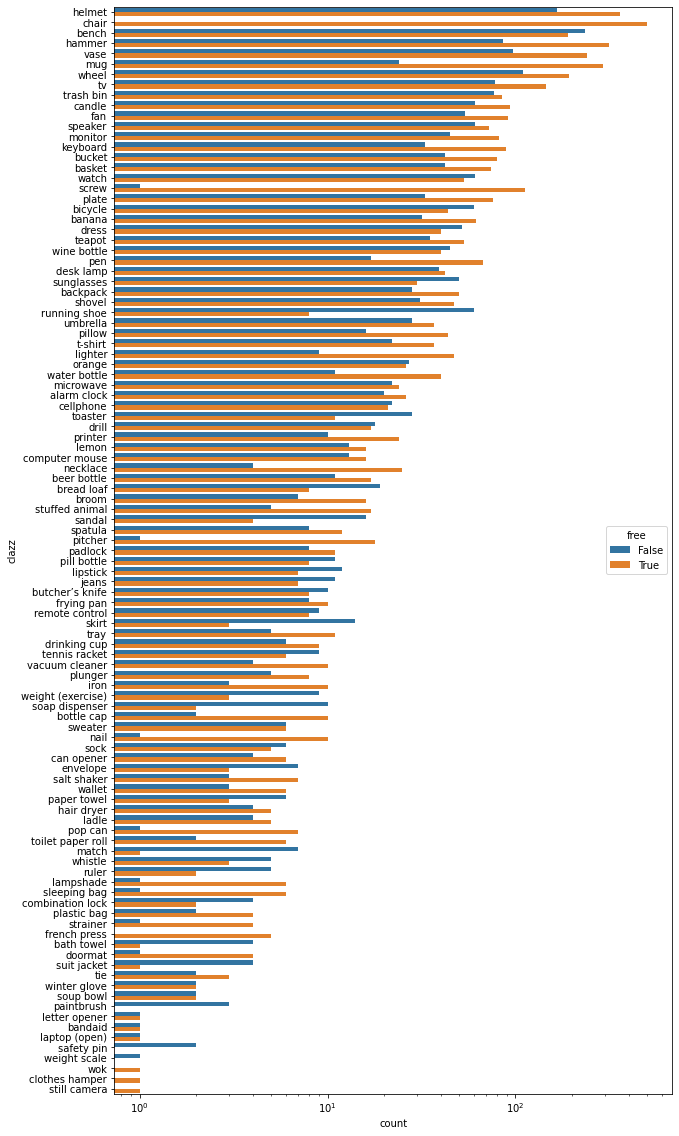

In [129]:
sns.countplot(y='clazz', hue='free', data=count_frame, order=count_frame['clazz'].value_counts().index, orient='h')
plt.gcf().set_size_inches((10, 20))
plt.gca().set_xscale('log')

In [184]:
import heapq

fast_index_dict = dict((a, b) for (b, a) in enumerate(classes))
class_queues = []
result_matrix = np.zeros((len(count_frame) + 1, len(classes)))
to_do = 0
cost_list = []
for clazz in classes:
    current_queue = []
    store = SelectionStore(clazz, './labeling/')
    free_count = 0
    cid = fast_index_dict[clazz]
    for k, v in store.store.items():
        if v:
            price = price_map[k]
            if price == 0:
                free_count += 1
            else:
                heapq.heappush(current_queue, price)
                to_do += 1
    result_matrix[0, cid] = free_count
    if len(current_queue):
        class_queues.append((free_count, cid, current_queue))
    
    

for i in range(1, to_do + 1):
    cc, cid, c_queue = heapq.heappop(class_queues)
    cc += 1
    c_price = heapq.heappop(c_queue)
    cost_list.append(c_price)
    result_matrix[i] = result_matrix[i-1]
    result_matrix[i, cid] = cc
    if len(c_queue):
        heapq.heappush(class_queues, (cc, cid, c_queue))
        
result_matrix = result_matrix[:to_do + 1]
len(cost_list)

2318

In [193]:
frame['price'].mean()

664.634876091854

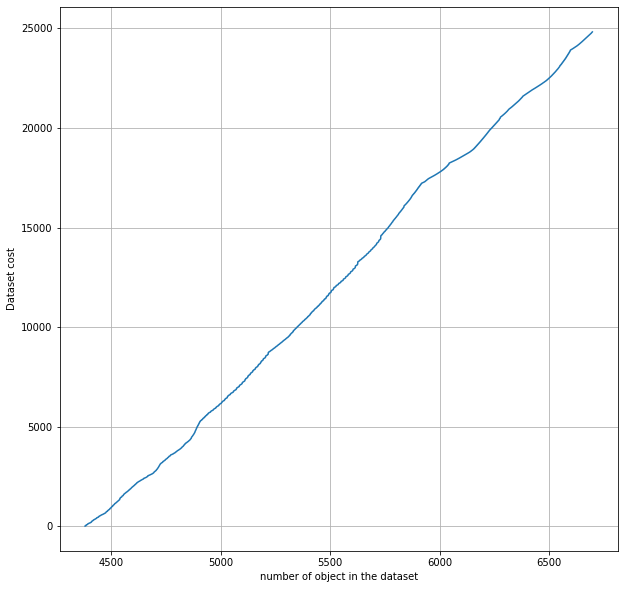

In [194]:
plt.plot(result_matrix.sum(1)[1:], np.cumsum(cost_list) / 100)
plt.xlabel('number of object in the dataset')
plt.ylabel('Dataset cost')
plt.grid()
plt.gcf().set_size_inches(10, 10)

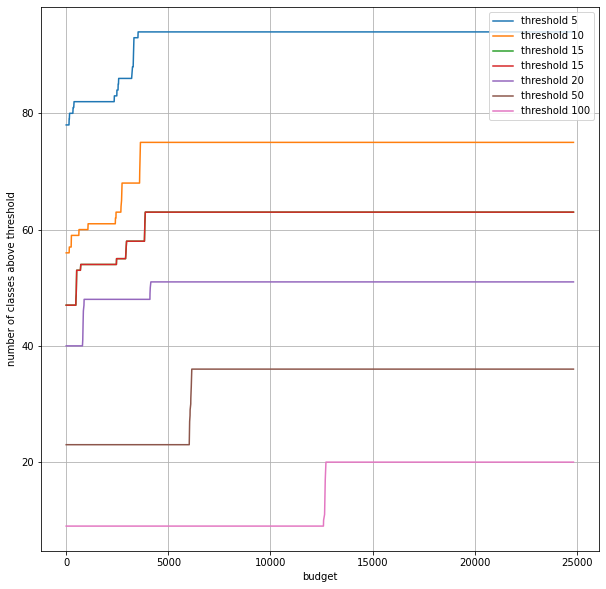

In [206]:
thresholds = [5, 10, 15, 15, 20, 50, 100]

for t in thresholds:
    serie = (result_matrix >= t).sum(1)
    plt.plot(np.cumsum(cost_list) / 100, serie[1:], label="threshold " + str(t))

plt.ylabel('number of classes above threshold')
plt.xlabel('budget')
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_size_inches(10, 10)
    

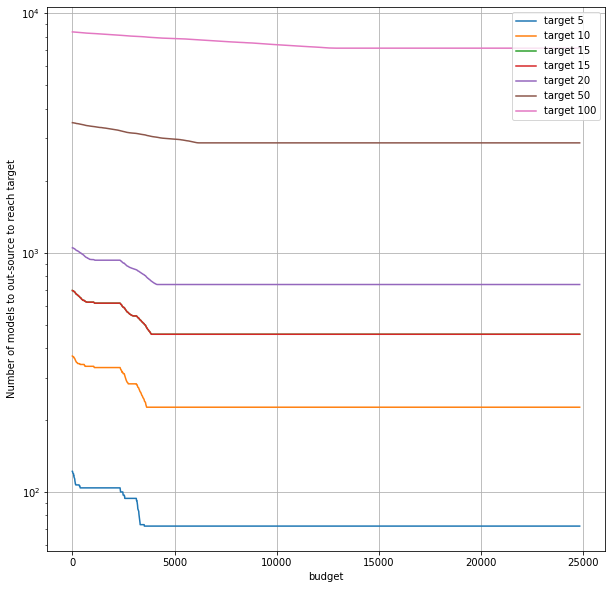

In [211]:
thresholds = [5, 10, 15, 15, 20, 50, 100]

for t in thresholds:
    missing = (np.clip(t - result_matrix, 0, np.inf)).sum(1)
    plt.plot(np.cumsum(cost_list) / 100, missing[1:], label="target " + str(t))

plt.ylabel('Number of models to out-source to reach target')
plt.xlabel('budget')
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_size_inches(10, 10)
    

In [142]:
dir(box)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_notifiers',
 '_call_widget_constructed',
 '_comm_changed',
 '_compare',
 '_cross_validation_lock',
 '_default_keys',
 '_display_callbacks',
 '_dom_classes',
 '_fire_children_displayed',
 '_gen_repr_from_keys',
 '_get_embed_state',
 '_handle_custom_msg',
 '_handle_displayed',
 '_handle_msg',
 '_holding_sync',
 '_ipython_display_',
 '_is_numpy',
 '_lock_property',
 '_log_default',
 '_model_id',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_msg_callbacks',
 '_notify_trait',
 '_property_lock',
 '_register_validator',
 '_remove_notifiers',
 '_repr_keys',
 '_s

In [105]:
page.store

{'215a41d8b6d44ecdbd70cc9680c0f585': True,
 '9076dcba7cce462a91218945ad47a6f7': False,
 '19f68e57f79c40658b1c6bbe434a0386': True,
 '6204a1f051ce4cba9b835a7611f875d8': False,
 '55b4e2046a954557abf8610b1ff45daf': False,
 '7a7fd4f74a9942258b6383653cefdb2f': True,
 'b73962e648c649b7aab04e35d85eca32': False,
 '73c023c90f8d45fb88294bccade836c0': True,
 'c0853768b05b42f8bad52841a8e62f6e': True,
 'b7832cf1396e4dcc9513e5e1acef182b': True}

In [26]:
frame.loc[frame['price'].argmax()]

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


embedUrl          https://sketchfab.com/models/a3e012cce63642b0a...
name                                      stygian zinogre - fan art
uid                                a3e012cce63642b0adfe2408d4c9a96e
reviewCount                                                       0
viewerUrl         https://sketchfab.com/3d-models/stygian-zinogr...
viewCount                                                       178
price                                                        500000
likeCount                                                        13
animationCount                                                    0
averageRating                                                   NaN
inStore                                                        True
class                                                           fan
image-0           https://media.sketchfab.com/models/a3e012cce63...
image-1           https://media.sketchfab.com/models/a3e012cce63...
image-2           https://media.sketchfab.com/mo